# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_182  P01602                     19.172
Sample_011  Q8NCL4                     17.371
Sample_098  A0A0J9YW40                 13.995
Sample_149  Q8TAB3;Q8TAB3-2;Q8TAB3-3   14.848
Sample_102  P30048;P30048-2            15.216
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups
Sample_165  Q86V85           12.877
Sample_104  P21579           15.942
Sample_027  Q9H741           14.086
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.962
            A0A075B6Q5                 13.061
            A0A075B6R2                 12.828
            A0A075B6S5                 10.986
            A0A087WSY4                 12.399
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.542
            Q9UI40;Q9UI40-2            11.391
            Q9UIW2                     12.548
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.014
            Q9UP79                     12.884
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.955,15.050,16.842,19.863,15.604,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.781,19.067,...,15.528,15.576,14.317,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.792,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.927,17.705,17.039,15.643,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.412,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.054,15.345,17.084,18.708,14.249,19.433,11.883,10.678
Sample_207,15.739,16.877,15.469,16.898,14.660,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.361,13.978,12.580,14.224,15.291,13.080,12.068,13.525,12.124,12.227
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.682,19.067,16.127,...,11.848,12.569,12.841,12.007,12.731,13.606,13.624,14.005,12.330,13.049
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.670,13.626,12.483,11.618,12.653,14.085,13.062,12.290,12.730,12.559
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.716,13.077,13.458,12.510,12.759,13.074,12.733,13.107,12.275,13.376
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.671,11.019,13.077,13.600,12.935,12.161,13.489,13.609,13.682,13.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.615,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 109.49it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.66it/s]

100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

100%|██████████| 3/3 [00:00<00:00,  4.31it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.67it/s]

100%|██████████| 4/4 [00:00<00:00,  4.11it/s]

100%|██████████| 4/4 [00:00<00:00,  4.43it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.56it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.43it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.06it/s]

100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.22it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.40it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.41it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.11it/s]

100%|██████████| 6/6 [00:01<00:00,  3.89it/s]

100%|██████████| 6/6 [00:01<00:00,  4.20it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.77it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.97it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.01it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.61it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.48it/s]

100%|██████████| 7/7 [00:02<00:00,  2.48it/s]

100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.89it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.45it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.12it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.14it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.14it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.95it/s]

100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.17it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.67it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.05it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.92it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.61it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.52it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.54it/s]

100%|██████████| 9/9 [00:02<00:00,  3.84it/s]

100%|██████████| 9/9 [00:02<00:00,  3.92it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.45it/s]

 30%|███       | 3/10 [00:00<00:01,  4.12it/s]

 40%|████      | 4/10 [00:00<00:01,  3.81it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.61it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.56it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.56it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.52it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.49it/s]

100%|██████████| 10/10 [00:02<00:00,  3.23it/s]

100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.96it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.16it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.42it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.30it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.46it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.60it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.71it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.81it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.64it/s]

100%|██████████| 11/11 [00:02<00:00,  3.94it/s]

100%|██████████| 11/11 [00:02<00:00,  4.04it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.35it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.70it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.10it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.77it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.91it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.93it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.00it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.04it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.09it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.18it/s]

100%|██████████| 12/12 [00:02<00:00,  4.22it/s]

100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.63it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.92it/s]

 31%|███       | 4/13 [00:00<00:02,  4.41it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.35it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.28it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.19it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.03it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  4.00it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.97it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.74it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.58it/s]

100%|██████████| 13/13 [00:03<00:00,  3.58it/s]

100%|██████████| 13/13 [00:03<00:00,  4.07it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.52it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.35it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.75it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.17it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.07it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.14it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.27it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.65it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.80it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.86it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.78it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.94it/s]

100%|██████████| 14/14 [00:03<00:00,  4.10it/s]

100%|██████████| 14/14 [00:03<00:00,  4.15it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.03it/s]

 20%|██        | 3/15 [00:00<00:02,  5.56it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.83it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.56it/s]

 40%|████      | 6/15 [00:01<00:02,  3.84it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.96it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.85it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.53it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.53it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.54it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.58it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.73it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.09it/s]

100%|██████████| 15/15 [00:03<00:00,  4.45it/s]

100%|██████████| 15/15 [00:03<00:00,  4.12it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.060 0.022          0.877 0.203       0.160   
2             0.004 0.002      0.049 0.014          0.673 0.120       0.555   
3             0.006 0.003      0.060 0.023          0.698 0.109       0.646   
4             0.005 0.002      0.055 0.023          0.723 0.098       0.676   
5             0.005 0.002      0.058 0.021          0.714 0.093       0.685   
6             0.006 0.002      0.060 0.021          0.819 0.076       0.816   
7             0.005 0.003      0.048 0.015          0.825 0.077       0.823   
8             0.007 0.004      0.063 0.027          0.822 0.079       0.816   
9             0.004 0.001      0.040 0.005          0.820 0.080       0.809   
10            0.005 0.003      0.049 0.018          0.811 0.091       0.798   
11            0.004 0.001      0.040 0.009          0.821 0.094       0.823   
12            0.004 0.001      0.041 0.011          0.821 0.085       0.832   
13            0.004 0.001      0.040 0.008          0.819 0.084       0.830   
14            0.004 0.001      0.040 0.010          0.826 0.082       0.818   
15            0.003 0.001      0.032 0.012          0.821 0.085       0.814   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.261 0.123                  0.572 0.042        0.865   
2          0.108   0.601 0.087                  0.675 0.065        0.732   
3          0.125   0.663 0.092                  0.716 0.074        0.804   
4          0.116   0.692 0.083                  0.740 0.066        0.838   
5          0.111   0.693 0.079                  0.740 0.064        0.830   
6          0.102   0.813 0.067                  0.841 0.055        0.906   
7          0.100   0.820 0.066                  0.846 0.055        0.905   
8          0.106   0.814 0.069                  0.842 0.057        0.903   
9          0.107   0.810 0.069                  0.838 0.058        0.902   
10         0.103   0.799 0.073                  0.829 0.061        0.902   
11         0.095   0.817 0.071                  0.843 0.061        0.913   
12         0.094   0.823 0.068                  0.848 0.059        0.915   
13         0.094   0.821 0.069                  0.846 0.060        0.915   
14         0.086   0.819 0.066                  0.845 0.057        0.919   
15         0.086   0.814 0.068                  0.841 0.059        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.830 0.089        210.000 0.000  
2          0.077                  0.691 0.097        210.000 0.000  
3          0.074                  0.734 0.097        210.000 0.000  
4          0.062                  0.800 0.085        210.000 0.000  
5          0.055                  0.788 0.084        210.000 0.000  
6          0.044                  0.882 0.057        210.000 0.000  
7          0.047                  0.881 0.056        210.000 0.000  
8          0.046                  0.879 0.055        210.000 0.000  
9          0.047                  0.876 0.058        210.000 0.000  
10         0.048                  0.878 0.057        210.000 0.000  
11         0.047                  0.899 0.051        210.000 0.000  
12         0.047                  0.903 0.051        210.000 0.000  
13         0.047                  0.903 0.050        210.000 0.000  
14         0.045                  0.909 0.047        210.000 0.000  
15         0.045                  0.909 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 524.09it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.09it/s]

100%|██████████| 2/2 [00:00<00:00,  7.07it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.37it/s]

100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.86it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.68it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.18it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.35it/s]

100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.33it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.26it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.73it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.68it/s]

100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.39it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.17it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.66it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.10it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.01it/s]

100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

100%|██████████| 7/7 [00:01<00:00,  4.32it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.63it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.71it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.86it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.63it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  5.03it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  5.34it/s]

100%|██████████| 8/8 [00:01<00:00,  5.77it/s]

100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.00it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.44it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.67it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.14it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.00it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.89it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.78it/s]

100%|██████████| 9/9 [00:02<00:00,  3.75it/s]

100%|██████████| 9/9 [00:02<00:00,  4.15it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.12it/s]

 30%|███       | 3/10 [00:00<00:01,  5.89it/s]

 40%|████      | 4/10 [00:00<00:01,  5.19it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.71it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.65it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.16it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.11it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.95it/s]

100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.44it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.62it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.10it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.14it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.18it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.57it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.29it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.33it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.29it/s]

100%|██████████| 11/11 [00:02<00:00,  4.17it/s]

100%|██████████| 11/11 [00:02<00:00,  4.34it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.89it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.70it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.08it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.22it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.15it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.87it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.70it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.73it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.72it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.72it/s]

100%|██████████| 12/12 [00:02<00:00,  3.67it/s]

100%|██████████| 12/12 [00:02<00:00,  4.05it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 14.40it/s]

 31%|███       | 4/13 [00:00<00:01,  8.13it/s]

 38%|███▊      | 5/13 [00:00<00:01,  7.38it/s]

 46%|████▌     | 6/13 [00:00<00:01,  6.87it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  6.77it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.59it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  6.34it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  6.15it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  6.05it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.94it/s]

100%|██████████| 13/13 [00:01<00:00,  5.88it/s]

100%|██████████| 13/13 [00:01<00:00,  6.58it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.50it/s]

 29%|██▊       | 4/14 [00:00<00:01,  9.74it/s]

 43%|████▎     | 6/14 [00:00<00:00,  8.74it/s]

 50%|█████     | 7/14 [00:00<00:00,  8.46it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  8.24it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  8.07it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  7.95it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  7.90it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  7.82it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  7.77it/s]

100%|██████████| 14/14 [00:01<00:00,  7.72it/s]

100%|██████████| 14/14 [00:01<00:00,  8.29it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.31it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.73it/s]

 40%|████      | 6/15 [00:00<00:01,  8.74it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.48it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.29it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.12it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.00it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  7.92it/s]

 80%|████████  | 12/15 [00:01<00:00,  7.87it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.83it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  7.76it/s]

100%|██████████| 15/15 [00:01<00:00,  7.73it/s]

100%|██████████| 15/15 [00:01<00:00,  8.28it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.043 0.010          0.057 0.201       0.007   
2             0.004 0.001      0.040 0.011          0.673 0.129       0.503   
3             0.005 0.002      0.051 0.018          0.761 0.090       0.713   
4             0.004 0.002      0.048 0.018          0.777 0.086       0.726   
5             0.004 0.002      0.042 0.013          0.762 0.082       0.720   
6             0.003 0.001      0.036 0.008          0.763 0.080       0.725   
7             0.004 0.001      0.035 0.003          0.788 0.096       0.761   
8             0.003 0.000      0.035 0.004          0.786 0.097       0.759   
9             0.003 0.001      0.032 0.007          0.794 0.100       0.738   
10            0.004 0.001      0.036 0.004          0.812 0.096       0.769   
11            0.003 0.001      0.026 0.005          0.831 0.089       0.787   
12            0.002 0.001      0.024 0.005          0.834 0.083       0.823   
13            0.002 0.000      0.022 0.001          0.836 0.085       0.824   
14            0.002 0.000      0.021 0.000          0.837 0.088       0.826   
15            0.002 0.000      0.021 0.000          0.851 0.086       0.850   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.026   0.012 0.044                  0.499 0.012        0.860   
2          0.122   0.565 0.102                  0.657 0.067        0.712   
3          0.103   0.731 0.077                  0.773 0.063        0.858   
4          0.102   0.747 0.079                  0.786 0.063        0.857   
5          0.102   0.736 0.075                  0.777 0.060        0.856   
6          0.111   0.738 0.076                  0.779 0.061        0.858   
7          0.107   0.767 0.071                  0.802 0.058        0.881   
8          0.116   0.766 0.079                  0.801 0.064        0.879   
9          0.118   0.759 0.086                  0.797 0.069        0.880   
10         0.118   0.784 0.084                  0.818 0.069        0.915   
11         0.102   0.804 0.075                  0.833 0.062        0.919   
12         0.105   0.824 0.073                  0.850 0.062        0.928   
13         0.107   0.825 0.073                  0.851 0.062        0.930   
14         0.108   0.827 0.075                  0.853 0.065        0.928   
15         0.107   0.846 0.075                  0.869 0.065        0.933   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.831 0.089        210.000 0.000  
2          0.073                  0.690 0.086        210.000 0.000  
3          0.059                  0.829 0.072        210.000 0.000  
4          0.057                  0.832 0.068        210.000 0.000  
5          0.057                  0.829 0.068        210.000 0.000  
6          0.057                  0.825 0.070        210.000 0.000  
7          0.056                  0.855 0.072        210.000 0.000  
8          0.056                  0.852 0.073        210.000 0.000  
9          0.056                  0.852 0.074        210.000 0.000  
10         0.046                  0.887 0.062        210.000 0.000  
11         0.044                  0.896 0.057        210.000 0.000  
12         0.042                  0.906 0.052        210.000 0.000  
13         0.041                  0.909 0.051        210.000 0.000  
14         0.041                  0.902 0.056        210.000 0.000  
15         0.040                  0.909 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1569.14it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 64.91it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 49.31it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 45.51it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 42.31it/s]

100%|██████████| 5/5 [00:00<00:00, 42.10it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 42.15it/s]

100%|██████████| 6/6 [00:00<00:00, 40.47it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 41.98it/s]

100%|██████████| 7/7 [00:00<00:00, 39.28it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 42.53it/s]

100%|██████████| 8/8 [00:00<00:00, 37.78it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 42.91it/s]

100%|██████████| 9/9 [00:00<00:00, 38.33it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 42.32it/s]

100%|██████████| 10/10 [00:00<00:00, 37.51it/s]

100%|██████████| 10/10 [00:00<00:00, 38.08it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 42.16it/s]

 91%|█████████ | 10/11 [00:00<00:00, 37.01it/s]

100%|██████████| 11/11 [00:00<00:00, 37.22it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 41.66it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 36.20it/s]

100%|██████████| 12/12 [00:00<00:00, 36.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 41.38it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 36.52it/s]

100%|██████████| 13/13 [00:00<00:00, 35.85it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 41.62it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 35.94it/s]

100%|██████████| 14/14 [00:00<00:00, 34.51it/s]

100%|██████████| 14/14 [00:00<00:00, 35.37it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 42.14it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 37.35it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 36.26it/s]

100%|██████████| 15/15 [00:00<00:00, 36.80it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.021 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.021 0.000          0.565 0.194       0.205   
3             0.002 0.000      0.021 0.000          0.524 0.194       0.245   
4             0.002 0.000      0.021 0.000          0.694 0.082       0.591   
5             0.002 0.000      0.021 0.000          0.701 0.092       0.591   
6             0.002 0.000      0.021 0.000          0.730 0.098       0.663   
7             0.002 0.000      0.021 0.000          0.740 0.097       0.683   
8             0.002 0.000      0.021 0.000          0.737 0.089       0.667   
9             0.002 0.000      0.021 0.000          0.719 0.086       0.653   
10            0.002 0.000      0.021 0.000          0.729 0.098       0.651   
11            0.002 0.000      0.021 0.000          0.730 0.097       0.650   
12            0.002 0.000      0.021 0.000          0.720 0.099       0.629   
13            0.002 0.000      0.021 0.000          0.709 0.103       0.619   
14            0.002 0.000      0.021 0.000          0.702 0.104       0.615   
15            0.002 0.000      0.021 0.000          0.693 0.105       0.616   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.761   
2          0.100   0.283 0.107                  0.534 0.046        0.632   
3          0.106   0.323 0.114                  0.537 0.059        0.617   
4          0.115   0.633 0.087                  0.700 0.061        0.778   
5          0.102   0.637 0.086                  0.703 0.065        0.779   
6          0.108   0.690 0.086                  0.740 0.069        0.829   
7          0.109   0.706 0.087                  0.752 0.070        0.826   
8          0.110   0.695 0.083                  0.745 0.065        0.825   
9          0.114   0.678 0.083                  0.731 0.063        0.822   
10         0.108   0.682 0.085                  0.734 0.067        0.825   
11         0.112   0.681 0.085                  0.734 0.067        0.826   
12         0.107   0.665 0.082                  0.722 0.065        0.821   
13         0.110   0.654 0.084                  0.713 0.066        0.818   
14         0.108   0.649 0.085                  0.709 0.067        0.814   
15         0.101   0.648 0.086                  0.706 0.070        0.810   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.686 0.089        210.000 0.000  
2          0.084                  0.565 0.092        210.000 0.000  
3          0.083                  0.554 0.087        210.000 0.000  
4          0.062                  0.714 0.077        210.000 0.000  
5          0.062                  0.717 0.077        210.000 0.000  
6          0.068                  0.784 0.083        210.000 0.000  
7          0.068                  0.780 0.085        210.000 0.000  
8          0.067                  0.779 0.083        210.000 0.000  
9          0.067                  0.777 0.082        210.000 0.000  
10         0.063                  0.782 0.080        210.000 0.000  
11         0.061                  0.780 0.080        210.000 0.000  
12         0.062                  0.773 0.081        210.000 0.000  
13         0.063                  0.771 0.082        210.000 0.000  
14         0.063                  0.767 0.082        210.000 0.000  
15         0.064                  0.765 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,3,15
score_time,8,3,13
test_precision,1,15,7
test_recall,12,15,7
test_f1,12,15,7
test_balanced_accuracy,12,15,7
test_roc_auc,14,15,6
test_average_precision,14,15,6
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.33it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.71it/s]

 40%|████      | 6/15 [00:00<00:01,  8.73it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.44it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.26it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.12it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.02it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  7.92it/s]

 80%|████████  | 12/15 [00:01<00:00,  7.88it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.83it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  7.79it/s]

100%|██████████| 15/15 [00:01<00:00,  7.77it/s]

100%|██████████| 15/15 [00:01<00:00,  8.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 41.37it/s]

100%|██████████| 6/6 [00:00<00:00, 39.24it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 17.36it/s]

 29%|██▊       | 4/14 [00:00<00:00, 11.01it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.90it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.44it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  9.47it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  9.48it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.27it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.11it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.21it/s]

100%|██████████| 14/14 [00:01<00:00,  9.29it/s]

100%|██████████| 14/14 [00:01<00:00,  9.67it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


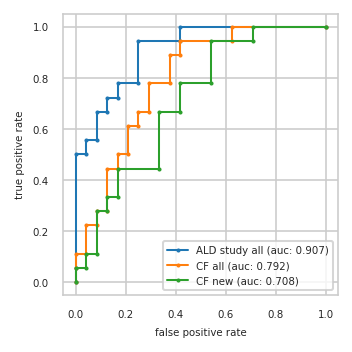

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.500  0.000 0.111  0.042 0.056
3          0.042 0.500  0.042 0.111  0.042 0.111
4          0.042 0.556  0.042 0.222  0.083 0.111
5          0.083 0.556  0.083 0.222  0.083 0.278
6          0.083 0.667  0.083 0.278  0.125 0.278
7          0.125 0.667  0.125 0.278  0.125 0.333
8          0.125 0.722  0.125 0.444  0.167 0.333
9          0.167 0.722  0.167 0.444  0.167 0.444
10         0.167 0.778  0.167 0.500  0.333 0.444
11         0.250 0.778  0.208 0.500  0.333 0.667
12         0.250 0.944  0.208 0.611  0.417 0.667
13         0.417 0.944  0.250 0.611  0.417 0.778
14         0.417 1.000  0.250 0.667  0.542 0.778
15         1.000 1.000  0.292 0.667  0.542 0.944
16           NaN   NaN  0.292 0.778  0.708 0.944
17           NaN   NaN  0.375 0.778  0.708 1.000
18           NaN   NaN  0.375 0.889  1.000 1.000
19           NaN   NaN  0.417 0.889    NaN   NaN
20           NaN   NaN  0.417 0.944    NaN   NaN
21           NaN   NaN  0.625 0.944    NaN   NaN
22           NaN   NaN  0.625 1.000    NaN   NaN
23           NaN   NaN  1.000 1.000    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P01701,H0Y7T8;P49418;P49418-2,P05997
2,P04114,P09960;P09960-4,P51688
3,Q8NCL4,Q14894,P31321
4,P61981,Q9Y2T3;Q9Y2T3-3,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
5,P09960;P09960-4,P61981,Q96GD0
6,Q9Y2T3;Q9Y2T3-3,P04075,None
7,P04075,P14174,None
8,P14174,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


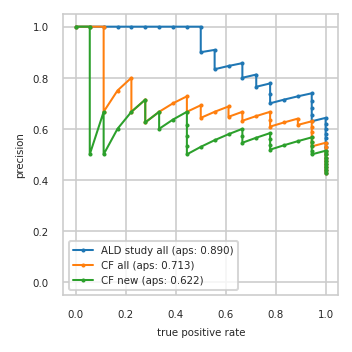

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.531 0.944     0.531 0.944
11         0.581 1.000     0.548 0.944     0.548 0.944
12         0.600 1.000     0.567 0.944     0.567 0.944
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.654 0.944     0.615 0.889     0.538 0.778
17         0.680 0.944     0.640 0.889     0.560 0.778
18         0.708 0.944     0.625 0.833     0.583 0.778
19         0.739 0.944     0.609 0.778     0.565 0.722
20         0.727 0.889     0.636 0.778     0.545 0.667
21         0.714 0.833     0.667 0.778     0.571 0.667
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.778 0.778     0.667 0.667     0.556 0.556
25         0.765 0.722     0.647 0.611     0.529 0.500
26         0.812 0.722     0.688 0.611     0.500 0.444
27         0.800 0.667     0.667 0.556     0.533 0.444
28         0.857 0.667     0.643 0.500     0.571 0.444
29         0.846 0.611     0.692 0.500     0.615 0.444
30         0.833 0.556     0.667 0.444     0.667 0.444
31         0.909 0.556     0.727 0.444     0.636 0.389
32         0.900 0.500     0.700 0.389     0.600 0.333
33         1.000 0.500     0.667 0.333     0.667 0.333
34         1.000 0.444     0.625 0.278     0.625 0.278
35         1.000 0.389     0.714 0.278     0.714 0.278
36         1.000 0.333     0.667 0.222     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     0.667 0.111     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


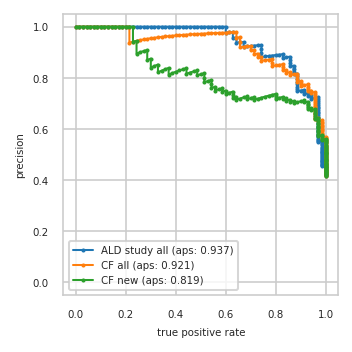

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


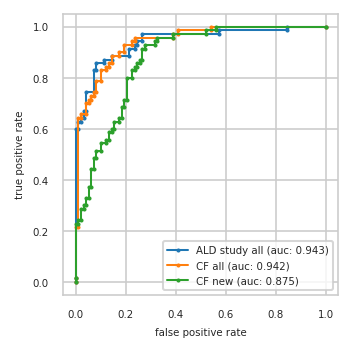

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}